
BERT WW COMPARISON: Vanilla BERT vs BERT+causal Tokens

🚀 Loading Vanilla BERT
   - model:     OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19
   - tokenizer: OUTPUT/RP/BERT_vanilla_batch16


Some weights of the model checkpoint at OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Loaded Vanilla BERT: vocab=30522, params=109,482,240, fp=9e3d4d4c49d67139be82a91d23ff6b76

🔬 WeightWatcher.analyze() for Vanilla BERT

🚀 Loading BERT+causal Tokens
   - model:     OUTPUT/RP/BERT_singleGPU/checkpoint-19
   - tokenizer: OUTPUT/RP/BERT_singleGPU


Some weights of the model checkpoint at OUTPUT/RP/BERT_singleGPU/checkpoint-19 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Loaded BERT+causal Tokens: vocab=30522, params=109,483,776, fp=7d69a74ea0b43717ff6e388e1a063611

🔬 WeightWatcher.analyze() for BERT+causal Tokens

COMPARISON RESULTS SUMMARY (Relevant Metrics)
           Metric  Vanilla BERT  BERT+causal Tokens  Difference
       alpha_mean        4.1003              4.1229      0.0226
        alpha_std        1.9319              1.8928     -0.0390
   alpha_weighted        5.6212              5.6410      0.0198
   log_alpha_norm        6.0647              6.0806      0.0158
log_spectral_norm        1.4728              1.4721     -0.0007
      stable_rank       57.6278             57.7615      0.1336
      mp_softrank        0.2588              0.2594      0.0006
    rand_distance        0.1379              0.1379     -0.0000
       num_spikes     3723.0000           3722.0000     -1.0000


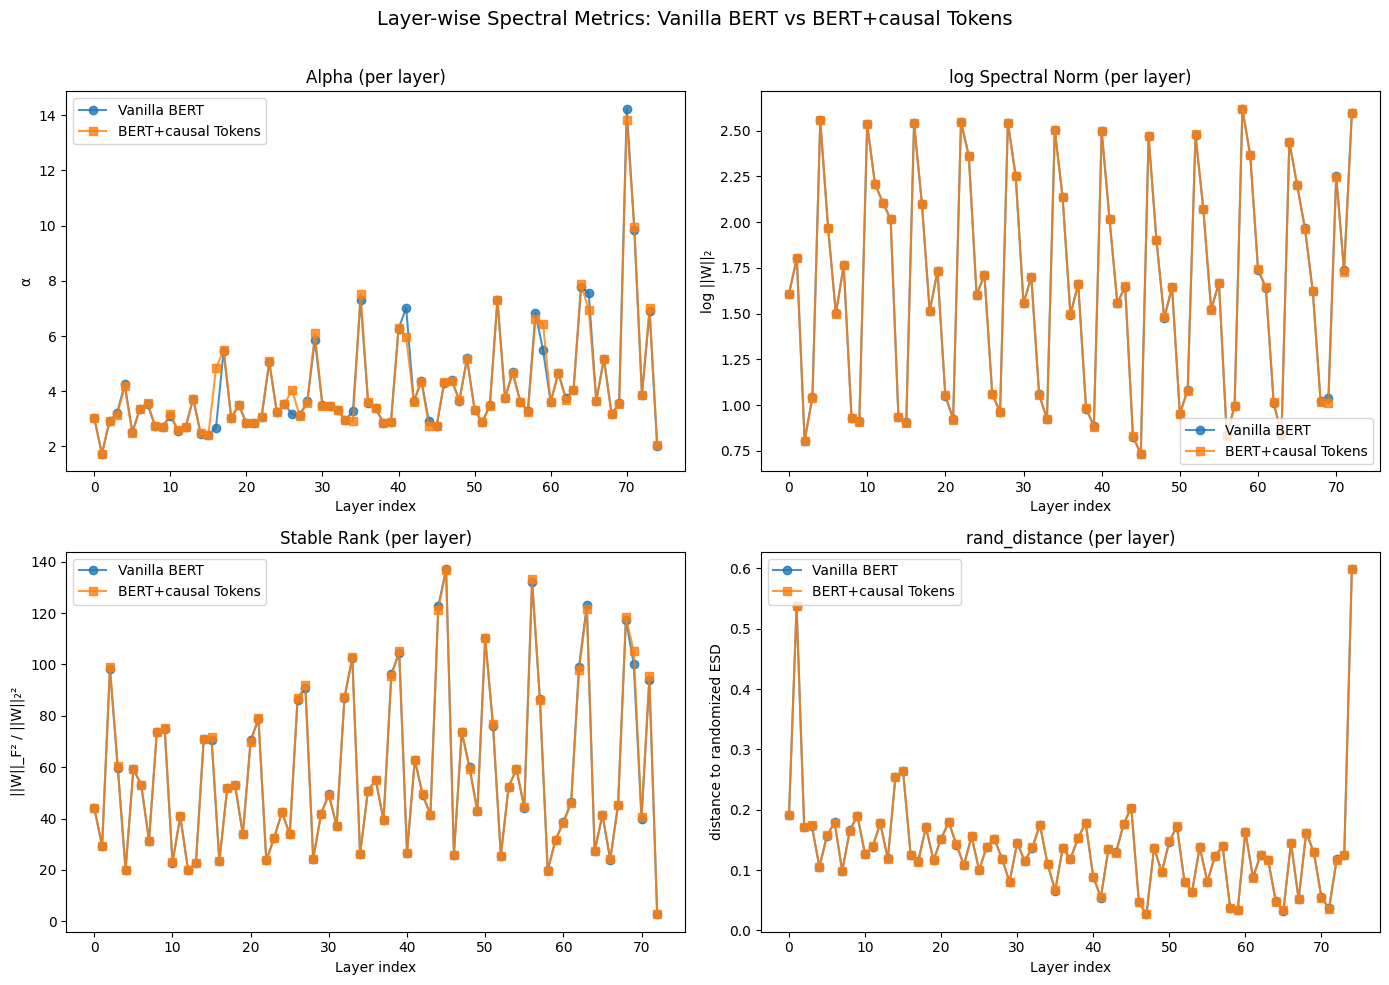

In [1]:
#!/usr/bin/env python3
"""
Lean WeightWatcher-based comparison for two Transformer models (BERT-friendly).
Collects:
- alpha_mean, alpha_std, alpha_weighted (if available), log_alpha_norm (if available)
- log_spectral_norm (per-layer + model-level mean)
- stable_rank (per-layer + model-level mean)
- mp_softrank (mean, if available)
- rand_distance (per-layer + mean, if available)
- num_spikes (sum, if available)

Includes layer-wise plots: alpha, log_spectral_norm, stable_rank, rand_distance (if present).
"""

import os
import warnings
import hashlib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import weightwatcher as ww

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
)

warnings.filterwarnings("ignore")
np.random.seed(0)  # deterministic sampling if any


# -------------------------------
# Utilities
# -------------------------------

def _safe_mean(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    return float(x.mean()) if x.size else np.nan


def _safe_sum(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    return float(x.sum()) if x.size else 0.0


def _resolve_tokenizer_source(model_path: str, tokenizer_path: str | None) -> str:
    """Prefer explicit tokenizer_path; else if model_path is a checkpoint dir, use its parent."""
    if tokenizer_path is not None:
        return tokenizer_path
    base = os.path.basename(model_path.rstrip("/"))
    if base.startswith("checkpoint-"):
        return os.path.dirname(model_path.rstrip("/"))
    return model_path


def _load_model_tokenizer(model_path, tokenizer_path=None):
    """Load config, tokenizer, and appropriate model class."""
    cfg = AutoConfig.from_pretrained(model_path)
    tok_src = _resolve_tokenizer_source(model_path, tokenizer_path)
    tokenizer = AutoTokenizer.from_pretrained(tok_src, use_fast=True)

    if getattr(cfg, "is_encoder_decoder", False):
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    elif getattr(cfg, "is_decoder", False) and not getattr(cfg, "is_encoder_decoder", False):
        model = AutoModelForCausalLM.from_pretrained(model_path)  # decoder-only (GPT/LLaMA/etc.)
    else:
        model = AutoModel.from_pretrained(model_path)  # encoder-only (BERT/RoBERTa/etc.)
    return model, tokenizer, cfg


def model_fingerprint(model, sample_keys=8) -> str:
    """Quick weight hash to verify two checkpoints differ."""
    sd = model.state_dict()
    keys = [k for k in sd.keys() if hasattr(sd[k], "dtype") and getattr(sd[k].dtype, "is_floating_point", False)]
    keys = sorted(keys)[:sample_keys]
    h = hashlib.md5()
    for k in keys:
        h.update(sd[k].detach().cpu().numpy().tobytes())
    return h.hexdigest()


# -------------------------------
# Analyzer
# -------------------------------

class BERTWWAnalyzer:
    def __init__(self, model_path, tokenizer_path=None, model_name="Model",
                 experimental=False, component=None):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        self.model_name = model_name
        self.experimental = experimental
        self.component = component  # "encoder" / "decoder" for encoder-decoder models; None for BERT

        print(f"\n🚀 Loading {self.model_name}")
        print(f"   - model:     {self.model_path}")
        print(f"   - tokenizer: {_resolve_tokenizer_source(self.model_path, self.tokenizer_path)}")

        # load
        self.model, self.tokenizer, self.cfg = _load_model_tokenizer(
            self.model_path, self.tokenizer_path
        )

        # pick submodule if requested (only meaningful for encoder-decoder)
        module = self.model
        if self.component == "encoder" and hasattr(self.model, "get_encoder"):
            module = self.model.get_encoder()
        elif self.component == "decoder" and hasattr(self.model, "get_decoder"):
            module = self.model.get_decoder()
        self.model = module
        self.model.eval()

        self.watcher = ww.WeightWatcher(model=self.model)

        # Outputs
        self.ww_details = None        # per-layer WW dataframe
        self.metrics = {}             # model-level relevant metrics
        self.layerwise = {}           # dict of per-layer arrays (alpha, log_spec, stable_rank, rand_distance)

        self._extract_weight_mats()   # for our own spectral metrics

        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"✅ Loaded {self.model_name}: vocab={getattr(self.tokenizer, 'vocab_size', 'N/A')}, "
              f"params={total_params:,}, fp={model_fingerprint(self.model)}")

    # ---------- helpers (static) ----------

    @staticmethod
    def _is_excluded_param(name: str, model=None) -> bool:
        n = name.lower()
        exclude_tokens = ["embed", "embedding", "embeddings", "tok_embedding", "wte", "lm_head"]
        exclude_norms  = ["layernorm", "layer_norm", "ln_", "ln.", "lnf", "rmsnorm", "norm.weight", "norm.bias", ".norm."]
        return any(s in n for s in (exclude_tokens + exclude_norms))

    @staticmethod
    def _is_tied_lm_head(model) -> bool:
        try:
            inp = getattr(model, "get_input_embeddings", lambda: None)()
            out = getattr(model, "get_output_embeddings", lambda: None)()
            return (inp is not None) and (out is not None) and \
                   (hasattr(out, "weight") and hasattr(inp, "weight") and
                    out.weight.data_ptr() == inp.weight.data_ptr())
        except Exception:
            return False

    @staticmethod
    def _to_2d(W: np.ndarray) -> np.ndarray | None:
        if W.ndim == 2:
            return W
        if W.ndim in (3, 4):  # conv/patch-embed
            return W.reshape(W.shape[0], -1)
        return None

    # ---------- Weight extraction & our per-layer spectral metrics ----------

    def _extract_weight_mats(self):
        """Extract 2D weight matrices (skip embeddings & LayerNorm)."""
        self.weight_mats, self.weight_names = [], []
        tied = self._is_tied_lm_head(self.model)
        for name, p in self.model.named_parameters():
            if "lm_head.weight" in name and tied:
                continue  # skip duplicate if tied to embeddings
            if ("weight" in name) and not self._is_excluded_param(name, self.model):
                W = p.detach().cpu().float().numpy()
                W2 = self._to_2d(W)
                if W2 is None:
                    continue
                self.weight_mats.append(W2)
                self.weight_names.append(name)

        # Compute spectral metrics per layer
        self.layerwise["log_spectral_norm"] = []
        self.layerwise["stable_rank"] = []
        for W in self.weight_mats:
            # singular values
            try:
                s = np.linalg.svd(W, compute_uv=False)
            except np.linalg.LinAlgError:
                s = np.array([np.nan])
            smax = np.nanmax(s) if s.size else np.nan
            fro2 = np.nansum(s**2)
            # stable rank = ||W||_F^2 / ||W||_2^2
            stable_rank = (fro2 / (smax**2)) if (np.isfinite(fro2) and np.isfinite(smax) and smax > 0) else np.nan
            self.layerwise["log_spectral_norm"].append(np.log(smax) if (np.isfinite(smax) and smax > 0) else np.nan)
            self.layerwise["stable_rank"].append(stable_rank)

        self.layerwise["log_spectral_norm"] = np.asarray(self.layerwise["log_spectral_norm"], dtype=float)
        self.layerwise["stable_rank"] = np.asarray(self.layerwise["stable_rank"], dtype=float)

    # ---------- WW analysis ----------

    def run_ww(self):
        """Run WeightWatcher with MP fits and randomization to get relevant columns."""
        print(f"\n🔬 WeightWatcher.analyze() for {self.model_name}")
        try:
            details = self.watcher.analyze(mp_fit=True, randomize=True, plot=False)
        except Exception as e:
            print(f"   ⚠️ WW analyze (randomize=True) failed: {e} → retrying with randomize=False")
            details = self.watcher.analyze(mp_fit=True, randomize=False, plot=False)

        self.ww_details = details

        # Per-layer alpha
        self.layerwise["alpha"] = details["alpha"].to_numpy(dtype=float) if "alpha" in details.columns else np.array([])

        # Per-layer rand_distance (if present)
        self.layerwise["rand_distance"] = (
            details["rand_distance"].to_numpy(dtype=float) if "rand_distance" in details.columns else np.array([])
        )

        # If WW also computed log_spectral_norm per layer
        if "log_spectral_norm" in details.columns:
            self.layerwise["log_spectral_norm_ww"] = details["log_spectral_norm"].to_numpy(dtype=float)

        self._compute_relevant_metrics()

        if self.experimental:
            self._compute_experimental_flow_metrics()

        return self.ww_details

    def _compute_relevant_metrics(self):
        d = self.ww_details

        # alpha stats
        if "alpha" in d.columns:
            alpha_vals = d["alpha"].to_numpy(dtype=float)
            self.metrics["alpha_mean"] = _safe_mean(alpha_vals)
            self.metrics["alpha_std"]  = float(np.nanstd(alpha_vals, ddof=0))

        # alpha_weighted (if provided)
        if "alpha_weighted" in d.columns:
            self.metrics["alpha_weighted"] = _safe_mean(d["alpha_weighted"])

        # log_alpha_norm (if provided)
        if "log_alpha_norm" in d.columns:
            self.metrics["log_alpha_norm"] = _safe_mean(d["log_alpha_norm"])

        # mp_softrank (per-layer; mean)
        if "mp_softrank" in d.columns:
            self.metrics["mp_softrank"] = _safe_mean(d["mp_softrank"])

        # rand_distance (per-layer; mean)
        if "rand_distance" in d.columns:
            self.metrics["rand_distance"] = _safe_mean(d["rand_distance"])

        # num_spikes (per-layer; sum)
        if "num_spikes" in d.columns:
            self.metrics["num_spikes"] = _safe_sum(d["num_spikes"])

        # log_spectral_norm: prefer WW's if present; else use ours (mean over layers)
        if "log_spectral_norm" in d.columns:
            self.metrics["log_spectral_norm"] = _safe_mean(d["log_spectral_norm"])
        else:
            self.metrics["log_spectral_norm"] = _safe_mean(self.layerwise["log_spectral_norm"])

        self.metrics["stable_rank"] = _safe_mean(self.layerwise["stable_rank"])

    # ---------- (Optional) Experimental old metrics ----------

    def _compute_experimental_flow_metrics(self, sample_size=5000):
        print(f"⚗️  Experimental flow metrics for {self.model_name}")
        flat = []
        for W in self.weight_mats:
            w = W.reshape(-1)
            if w.size > sample_size:
                idx = np.random.choice(w.size, sample_size, replace=False)
                w = w[idx]
            flat.append(w.astype(np.float64))

        if not flat:
            return

        n = len(flat)
        C = np.eye(n)
        for i in range(n):
            for j in range(i + 1, n):
                a, b = flat[i], flat[j]
                m = min(a.size, b.size)
                if m == 0:
                    c = np.nan
                else:
                    a0, b0 = a[:m], b[:m]
                    ac = a0 - a0.mean()
                    bc = b0 - b0.mean()
                    denom = np.linalg.norm(ac) * np.linalg.norm(bc)
                    c = (ac @ bc) / denom if denom > 0 else np.nan
                C[i, j] = C[j, i] = c if np.isfinite(c) else 0.0

        tri = np.triu(C, 1)
        nz = tri[tri != 0]
        self.metrics["global_correlation_strength"] = float(np.mean(np.abs(nz))) if nz.size else 0.0


# -------------------------------
# Reporting & Plotting
# -------------------------------

def print_model_summary(an1: BERTWWAnalyzer, an2: BERTWWAnalyzer):
    keys = [
        "alpha_mean", "alpha_std", "alpha_weighted", "log_alpha_norm",
        "log_spectral_norm", "stable_rank", "mp_softrank",
        "rand_distance", "num_spikes"
    ]
    rows = []
    for k in keys:
        v1 = an1.metrics.get(k, np.nan)
        v2 = an2.metrics.get(k, np.nan)
        diff = (v2 - v1) if (np.isfinite(v1) and np.isfinite(v2)) else np.nan
        rows.append([k, v1, v2, diff])
    df = pd.DataFrame(rows, columns=["Metric", an1.model_name, an2.model_name, "Difference"])
    with pd.option_context("display.float_format", lambda x: f"{x:.4f}"):
        print("\n" + "="*80)
        print("COMPARISON RESULTS SUMMARY (Relevant Metrics)")
        print("="*80)
        print(df.to_string(index=False))
    return df


def plot_layerwise(an1: BERTWWAnalyzer, an2: BERTWWAnalyzer):
    """2x2 grid: alpha, log_spectral_norm, stable_rank, rand_distance (if present)."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Layer-wise Spectral Metrics: {an1.model_name} vs {an2.model_name}", fontsize=14)

    # Alpha (WW)
    ax = axes[0, 0]
    if an1.layerwise.get("alpha", np.array([])).size:
        ax.plot(an1.layerwise["alpha"], "o-", label=an1.model_name, alpha=0.8)
    if an2.layerwise.get("alpha", np.array([])).size:
        ax.plot(an2.layerwise["alpha"], "s-", label=an2.model_name, alpha=0.8)
    ax.set_title("Alpha (per layer)")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("α")
    ax.legend()

    # log_spectral_norm (ours)
    ax = axes[0, 1]
    ax.plot(an1.layerwise["log_spectral_norm"], "o-", label=an1.model_name, alpha=0.8)
    ax.plot(an2.layerwise["log_spectral_norm"], "s-", label=an2.model_name, alpha=0.8)
    ax.set_title("log Spectral Norm (per layer)")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("log ||W||₂")
    ax.legend()

    # stable_rank (ours)
    ax = axes[1, 0]
    ax.plot(an1.layerwise["stable_rank"], "o-", label=an1.model_name, alpha=0.8)
    ax.plot(an2.layerwise["stable_rank"], "s-", label=an2.model_name, alpha=0.8)
    ax.set_title("Stable Rank (per layer)")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("||W||_F² / ||W||₂²")
    ax.legend()

    # rand_distance (WW, if present)
    ax = axes[1, 1]
    has1 = an1.layerwise.get("rand_distance", np.array([])).size > 0
    has2 = an2.layerwise.get("rand_distance", np.array([])).size > 0
    if has1:
        ax.plot(an1.layerwise["rand_distance"], "o-", label=an1.model_name, alpha=0.8)
    if has2:
        ax.plot(an2.layerwise["rand_distance"], "s-", label=an2.model_name, alpha=0.8)
    ax.set_title("rand_distance (per layer)")
    ax.set_xlabel("Layer index")
    ax.set_ylabel("distance to randomized ESD")
    if has1 or has2:
        ax.legend()
    else:
        ax.text(0.5, 0.5, "rand_distance not available", ha="center", va="center", alpha=0.6)
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# -------------------------------
# Driver
# -------------------------------

def compare_two_bert_models(model1_path, model2_path,
                            tokenizer1_path=None, tokenizer2_path=None,
                            model1_name="Model 1", model2_name="Model 2",
                            experimental=False, component=None):
    print(f"\n{'='*80}\nBERT WW COMPARISON: {model1_name} vs {model2_name}\n{'='*80}")

    an1 = BERTWWAnalyzer(model1_path, tokenizer1_path, model1_name,
                         experimental=experimental, component=component)
    an1.run_ww()

    an2 = BERTWWAnalyzer(model2_path, tokenizer2_path, model2_name,
                         experimental=experimental, component=component)
    an2.run_ww()

    df = print_model_summary(an1, an2)
    plot_layerwise(an1, an2)
    return an1, an2, df


if __name__ == "__main__":
    # Example local paths (change to yours)
    model1_path = "OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19"
    tokenizer1_path = "OUTPUT/RP/BERT_vanilla_batch16"  # NOTE: parent of checkpoint
    model2_path = "OUTPUT/RP/BERT_singleGPU/checkpoint-19"
    tokenizer2_path = "OUTPUT/RP/BERT_singleGPU"                  # NOTE: parent of checkpoint

    if not (os.path.isdir(model1_path) and os.path.isdir(model2_path)):
        print("\n---")
        print("⚠️  Warning: Custom model paths not found. Please update the paths.")
        print(f"   - Model 1: {model1_path}")
        print(f"   - Model 2: {model2_path}")
        print("---\n")
    else:
        compare_two_bert_models(
            model1_path=model1_path,
            model2_path=model2_path,
            tokenizer1_path=tokenizer1_path,
            tokenizer2_path=tokenizer2_path,
            model1_name="Vanilla BERT",
            model2_name="BERT+causal Tokens",
            experimental=False,
            component=None,  # keep None for BERT
        )



BERT LAYER PATTERN COMPARISON ('intermediate'): BERT Original vs BERT Modified

🚀 Loading BERT Original
   - model:     OUTPUT/RP/BERT/checkpoint-19
   - tokenizer: OUTPUT/RP/BERT


Some weights of the model checkpoint at OUTPUT/RP/BERT/checkpoint-19 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Selected 12 layers for analysis:
  - encoder.layer.0.intermediate.dense.weight
  - encoder.layer.1.intermediate.dense.weight
  - encoder.layer.2.intermediate.dense.weight
  - encoder.layer.3.intermediate.dense.weight
  - encoder.layer.4.intermediate.dense.weight
  - encoder.layer.5.intermediate.dense.weight
  - encoder.layer.6.intermediate.dense.weight
  - encoder.layer.7.intermediate.dense.weight
  - encoder.layer.8.intermediate.dense.weight
  - encoder.layer.9.intermediate.dense.weight
  - encoder.layer.10.intermediate.dense.weight
  - encoder.layer.11.intermediate.dense.weight
✅ Loaded BERT Original: vocab=30522, params=109,482,240, fp=b22667af0c1655e8ddec8f3e4c7673e7

🔬 WeightWatcher.analyze() for BERT Original

🚀 Loading BERT Modified
   - model:     OUTPUT/RP/BERT_singleGPU/checkpoint-19
   - tokenizer: OUTPUT/RP/BERT_singleGPU


Some weights of the model checkpoint at OUTPUT/RP/BERT_singleGPU/checkpoint-19 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Selected 12 layers for analysis:
  - encoder.layer.0.intermediate.dense.weight
  - encoder.layer.1.intermediate.dense.weight
  - encoder.layer.2.intermediate.dense.weight
  - encoder.layer.3.intermediate.dense.weight
  - encoder.layer.4.intermediate.dense.weight
  - encoder.layer.5.intermediate.dense.weight
  - encoder.layer.6.intermediate.dense.weight
  - encoder.layer.7.intermediate.dense.weight
  - encoder.layer.8.intermediate.dense.weight
  - encoder.layer.9.intermediate.dense.weight
  - encoder.layer.10.intermediate.dense.weight
  - encoder.layer.11.intermediate.dense.weight
✅ Loaded BERT Modified: vocab=30522, params=109,483,776, fp=7d69a74ea0b43717ff6e388e1a063611

🔬 WeightWatcher.analyze() for BERT Modified

COMPARISON RESULTS SUMMARY (Relevant Metrics)
           Metric  BERT Original  BERT Modified  Difference
       alpha_mean         4.2242         4.1229     -0.1014
        alpha_std         2.0420         1.8928     -0.1492
   alpha_weighted         5.7072         5.6410 

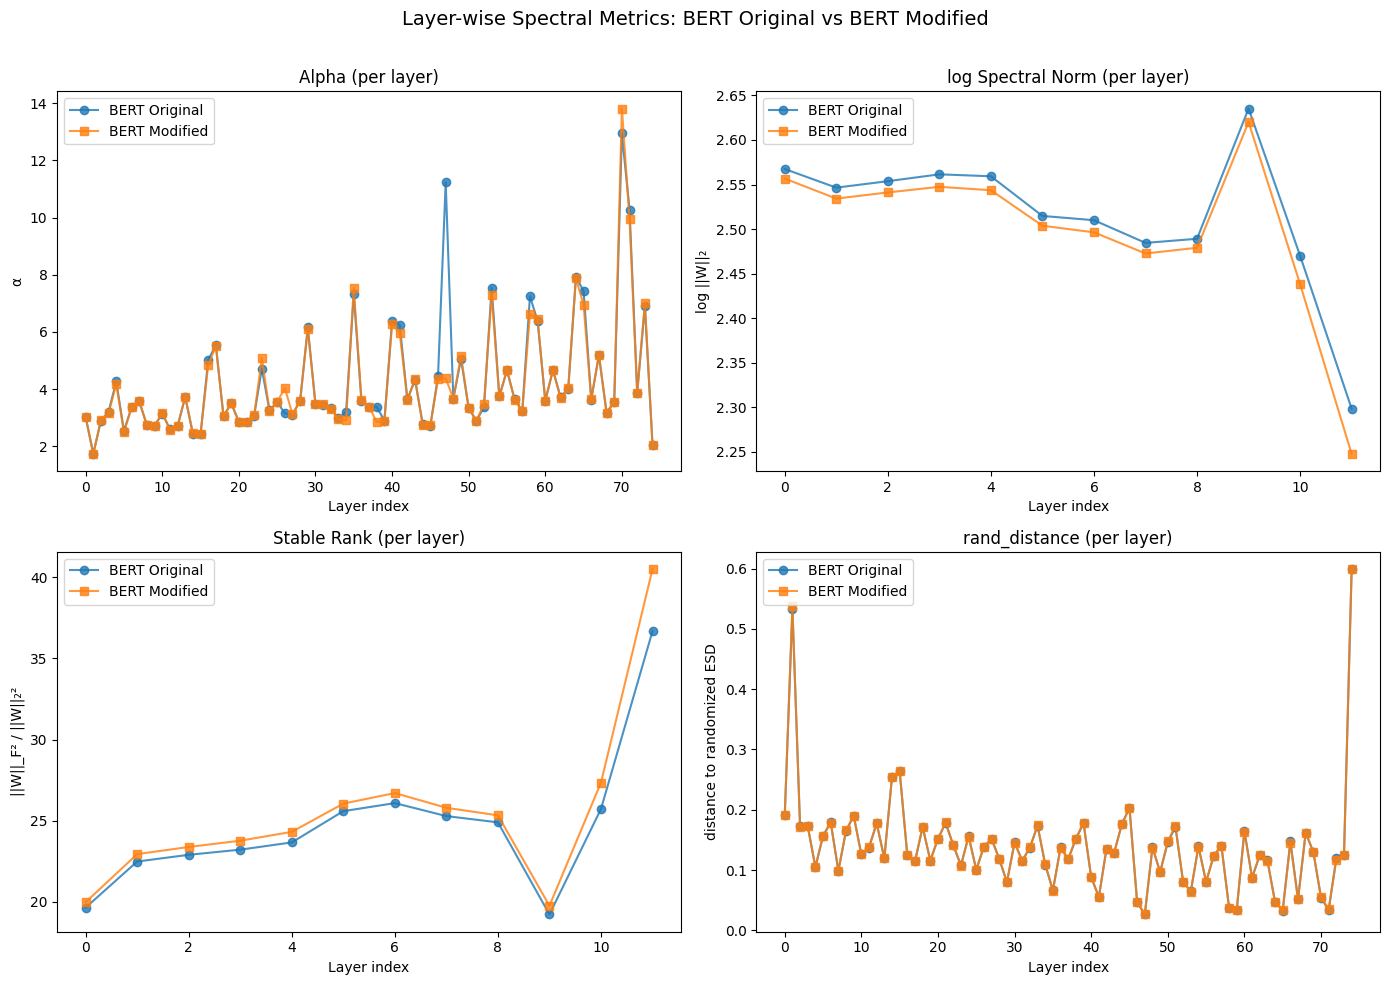

TypeError: compare_attention_layers_only() got an unexpected keyword argument 'model1_path'

In [ ]:
def create_layer_subset_analyzer(base_analyzer_class):
    """Factory function to create a modified analyzer that uses only specific layers"""
    
    class LayerSubsetAnalyzer(base_analyzer_class):
        def __init__(self, model_path, tokenizer_path=None, model_name="Model", 
                     experimental=False, layer_indices=None, layer_pattern=None):
            """
            Args:
                layer_indices: List of specific layer indices to analyze (e.g., [0, 5, 11])
                layer_pattern: String pattern to match layer names (e.g., "attention", "intermediate")
            """
            self.layer_indices = layer_indices
            self.layer_pattern = layer_pattern
            super().__init__(model_path, tokenizer_path, model_name, experimental)
        
        def _extract_weight_mats(self):
            """Extract 2D weight matrices from specific layers only."""
            self.weight_mats, self.weight_names = [], []
            tied = self._is_tied_lm_head(self.model)
            
            for name, p in self.model.named_parameters():
                if "lm_head.weight" in name and tied:
                    continue
                
                # Skip if not in specified layers
                if not self._should_include_layer(name):
                    continue
                    
                if ("weight" in name) and not self._is_excluded_param(name, self.model):
                    W = p.detach().cpu().float().numpy()
                    W2 = self._to_2d(W)
                    if W2 is None: 
                        continue
                    self.weight_mats.append(W2)
                    self.weight_names.append(name)
            
            print(f"Selected {len(self.weight_mats)} layers for analysis:")
            for name in self.weight_names:
                print(f"  - {name}")

            # Compute spectral metrics for selected layers only
            self.layerwise["log_spectral_norm"] = []
            self.layerwise["stable_rank"] = []
            for W in self.weight_mats:
                try:
                    s = np.linalg.svd(W, compute_uv=False)
                except np.linalg.LinAlgError:
                    s = np.array([np.nan])
                smax = np.nanmax(s) if s.size else np.nan
                fro2 = np.nansum(s**2)
                stable_rank = (fro2 / (smax**2)) if (np.isfinite(fro2) and np.isfinite(smax) and smax > 0) else np.nan
                self.layerwise["log_spectral_norm"].append(np.log(smax) if (np.isfinite(smax) and smax > 0) else np.nan)
                self.layerwise["stable_rank"].append(stable_rank)

            self.layerwise["log_spectral_norm"] = np.asarray(self.layerwise["log_spectral_norm"], dtype=float)
            self.layerwise["stable_rank"] = np.asarray(self.layerwise["stable_rank"], dtype=float)
        
        def _should_include_layer(self, layer_name):
            """Check if a layer should be included based on indices or pattern."""
            if self.layer_indices is not None:
                # Extract layer number from name (works for BERT-style naming)
                import re
                layer_num_match = re.search(r'layer\.(\d+)\.', layer_name)
                if layer_num_match:
                    layer_num = int(layer_num_match.group(1))
                    return layer_num in self.layer_indices
                else:
                    return False
            
            if self.layer_pattern is not None:
                return self.layer_pattern.lower() in layer_name.lower()
            
            # If neither specified, include all layers (default behavior)
            return True
    
    return LayerSubsetAnalyzer

# Create the specialized analyzer class
BERTLayerSubsetAnalyzer = create_layer_subset_analyzer(BERTWWAnalyzer)

def compare_models_with_layer_subset(model1_path, model2_path,
                                   tokenizer1_path, tokenizer2_path,
                                   model1_name="Model 1", model2_name="Model 2",
                                   layer_indices=None, layer_pattern=None,
                                   experimental=False):
    """
    Compare two models using only specific layers.
    
    Args:
        layer_indices: List of layer indices to analyze (e.g., [0, 5, 11] for first, middle, last)
        layer_pattern: Pattern to match layer names (e.g., "attention" for attention layers only)
    """
    print(f"\n{'='*80}")
    if layer_indices:
        print(f"BERT LAYER SUBSET COMPARISON (layers {layer_indices}): {model1_name} vs {model2_name}")
    elif layer_pattern:
        print(f"BERT LAYER PATTERN COMPARISON ('{layer_pattern}'): {model1_name} vs {model2_name}")
    print(f"{'='*80}")

    an1 = BERTLayerSubsetAnalyzer(
        model1_path, tokenizer1_path, model1_name, 
        experimental=experimental, layer_indices=layer_indices, layer_pattern=layer_pattern
    )
    an1.run_ww()

    an2 = BERTLayerSubsetAnalyzer(
        model2_path, tokenizer2_path, model2_name,
        experimental=experimental, layer_indices=layer_indices, layer_pattern=layer_pattern
    )
    an2.run_ww()

    df = print_model_summary(an1, an2)
    plot_layerwise(an1, an2)
    return an1, an2, df

# Example usage functions
def compare_attention_layers_only():
    """Compare only attention layers"""
    return compare_models_with_layer_subset(
        model1_path="OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19",
        model2_path="OUTPUT/RP/BERT_singleGPU/checkpoint-19",
        tokenizer1_path="OUTPUT/RP/BERT_vanilla_batch16",
        tokenizer2_path="OUTPUT/RP/BERT_singleGPU",
        model1_name="BERT_vanilla_batch16",
        model2_name="BERT Modified",
        layer_pattern="attention"
    )

def compare_first_middle_last_layers():
    """Compare only first, middle, and last layers (for 12-layer BERT)"""
    return compare_models_with_layer_subset(
        model1_path="OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19",
        model2_path="OUTPUT/RP/BERT_singleGPU/checkpoint-19",
        tokenizer1_path="OUTPUT/RP/BERT_vanilla_batch16",
        tokenizer2_path="OUTPUT/RP/BERT_singleGPU",
        model1_name="BERT_vanilla_batch16",
        model2_name="BERT Modified",
        layer_indices=[0, 5, 11]  # First, middle, last for 12-layer BERT
    )

def compare_specific_layers(layer_list):
    """Compare specific layers by index"""
    return compare_models_with_layer_subset(
        model1_path="OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19",
        model2_path="OUTPUT/RP/BERT_singleGPU/checkpoint-19",
        tokenizer1_path="OUTPUT/RP/BERT_vanilla_batch16",
        tokenizer2_path="OUTPUT/RP/BERT_singleGPU",
        model1_name="BERT_vanilla_batch16",
        model2_name="BERT Modified",
        layer_indices=layer_list
    )

# Example calls:
# compare_attention_layers_only()
# compare_first_middle_last_layers() 
# compare_specific_layers([2, 4, 6, 8])  # Compare layers 2, 4, 6, 8

compare_models_with_layer_subset(
    model1_path="OUTPUT/RP/BERT_vanilla_batch16/checkpoint-19",
    model2_path="OUTPUT/RP/BERT_singleGPU/checkpoint-19", 
    tokenizer1_path="OUTPUT/RP/BERT_vanilla_batch16",
    tokenizer2_path="OUTPUT/RP/BERT_singleGPU",
    model1_name="BERT_vanilla_batch16",
    model2_name="BERT_singleGPU",
    layer_pattern="intermediate"
)

compare_attention_layers_only()

compare_first_middle_last_layers()
